In [1]:
import numpy as np
import pandas as pd

In [2]:
def nse(targets,predictions):
    return 1-(np.sum((targets-predictions)**2)/np.sum((targets-np.mean(predictions))**2))

def max_pct(targets,predictions):
    p = np.max(predictions)
    t = np.max(targets)
    return (p-t)/t

def min_pct(targets,predictions):
    p = np.min(predictions)
    t = np.min(targets)
    return (p-t)/t

def mean_pct(targets,predictions):
    p = np.mean(predictions)
    t = np.mean(targets)
    return (p-t)/t


def compare_stats(targets, predictions):
    return {
        'nse': nse(targets,predictions),
        'max_pct': max_pct(targets,predictions),
        'min_pct':min_pct(targets,predictions),
        'mean_pct': mean_pct(targets,predictions)
    }



In [3]:
def read_result(excel_path, tab_name, datetime_fld, timestep):
    df = pd.read_excel(excel_path, tab_name)
    df.index = pd.to_datetime(df[datetime_fld])
    df = df.resample(timestep).ffill()
    df.columns = [x.strip() for x in df.columns]
    return df

def join_results(target, predict, target_fld, predict_fld):
    df = target.loc[:, [target_fld]].join(predict.loc[:, [predict_fld]])
    return df

def compare(results, target_fld, predict_fld):

    return compare_stats(results[target_fld].values, results[predict_fld].values)


def read_excel(excel_file, mapping, timestep):
    data = {}
        
    for k, v in mapping.items():
        # print(k)
        data[k] = {'df': read_result(excel_path=f, tab_name=v['tab'], datetime_fld=v['datetime_fld'], timestep=timestep)}
    return data


def merge_results(data, mapping, field):
    result = None
    for k, v in mapping.items():
        fld = v[field]
        df = data[k]['df'].loc[:, [fld]]
        df[k] = df[fld]
        if result is None:
            result = df.loc[:, [k]]
        else:
            result = result.join(df.loc[:, [k]])
    return result.interpolate()

def compare_summary(result, mapping, target):
    result = result.interpolate()
    data = []
    for fld in mapping:
        if fld == target:
            pass
        else:
            r = compare(result, target_fld=target, predict_fld=fld)
            r['model'] = fld
            data.append(r)
            print('Compare {} to {} runoff'.format(fld, target))
            print(r)
    return pd.DataFrame(data)



In [4]:
f = 'data.xlsx'
mapping = {
        'icm_swmm': {'SCS_CN': 'runoff_curve_number#1', 'Horton': 'runoff_horton#1', 'Green_Ampt': 'runoff_green_ampt#1', 
                     'Horton_modifed': 'runoff_horton_modified', 'SCS_CN_NO_IA': 'runoff_curve_number_no_ia', 'Green_Ampt_modified': 'runoff_green_ampt_modified', 
                      'datetime_fld': 'datetime', 'Uniform': 'runoff_uniform#1', 'tab': 'icm_swmm'},
        'icm_sim': {'SCS_CN': 'runoff_curve_number#1', 'Horton': 'runoff_horton_swmm', 'Green_Ampt': 'runoff_green_ampt#1', 
                    'SCS_CN_NO_IA': 'cn_swmm_no_ia',
                    'Horton_modifed': 'runoff_horton#1', 'Green_Ampt_modified': 'runoff_green_ampt#1',
                      'datetime_fld': 'datetime', 'Uniform': 'runoff_uniform#1', 'tab': 'icm_sim'},
        'XPSWMM': {'SCS_CN': 'runoff_curve', 'Horton': 'runoff_horto', 'Green_Ampt': 'runoff_green', 
                   'Horton_modifed': 'runoff_horto', 'SCS_CN_NO_IA': 'runoff_curve_no_ia', 'Green_Ampt_modified': 'runoff_green', 
                   'datetime_fld': 'datetime', 'Uniform': 'runoff_unifo', 'tab': 'XPSWMM'}
        }

# reported results timestep, make sure each model is set the same.
timestep = '1min'

# Infiltration Method Comparison

* Horton: XPSWMM Horton vs SWMM Horton vs sim SWMMHorton
* Horton Modified:  SWMM Modified Horton vs sim Horton
  * XPSWMM Horton does not support this method 
* Green Ampt: XPSWMM Green Ampt vs SWMM Green Ampt vs ICM Green Ampt
* Modified Green Ampt: SWMM Modifed Green Ampt
  * XPSWMM and Sim Green Ampt have no support
* SCS CN: with IA set for XPSWMM SCS CN vs Sim CN
  * SWMM CN has no support for IA
* SCS CN NO IA: XPSWMM SCS CN no IA vs SWMM CN s Sim CNSWMM




In [5]:
# read all the tabs into dataframe
data = read_excel(f, mapping, timestep)

C:\Users\mengm\AppData\Local\Temp\ipykernel_5936\995160268.py:12: RuntimeWarning: invalid value encountered in double_scalars
  return (p-t)/t


Text(0.5, 1.0, 'XPSWMM with vs without IA, NSE=0.93, Max diff=-0.25, Mean diff=-0.23')

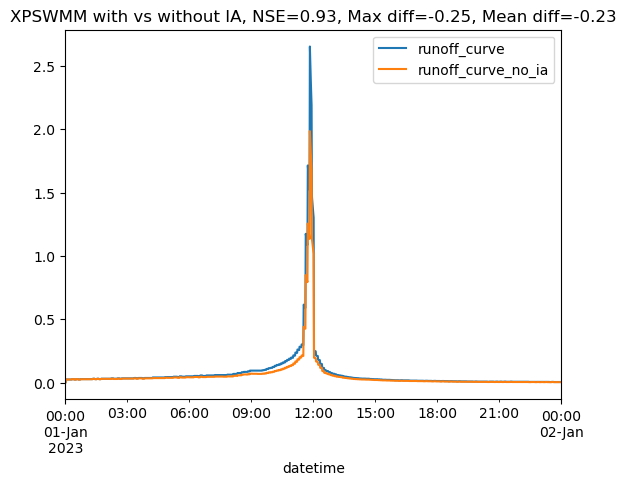

In [12]:
df = read_result(f, 'XPSWMM', 'datetime', timestep)
target_fld='runoff_curve'
predict_fld='runoff_curve_no_ia'
ax = df.loc[:, [target_fld, predict_fld]].plot(subplots=False)
s = compare(df, target_fld, predict_fld)
title = 'XPSWMM with vs without IA, NSE={nse:.2f}, Max diff={max_pct:.2f}, Mean diff={mean_pct:.2f}'.format(**s)
ax.set_title(title)

C:\Users\mengm\AppData\Local\Temp\ipykernel_5936\995160268.py:12: RuntimeWarning: invalid value encountered in double_scalars
  return (p-t)/t


Text(0.5, 1.0, 'SIM CN vs CNSWMM NSE=0.92, Max diff=-0.24, Mean diff=0.09')

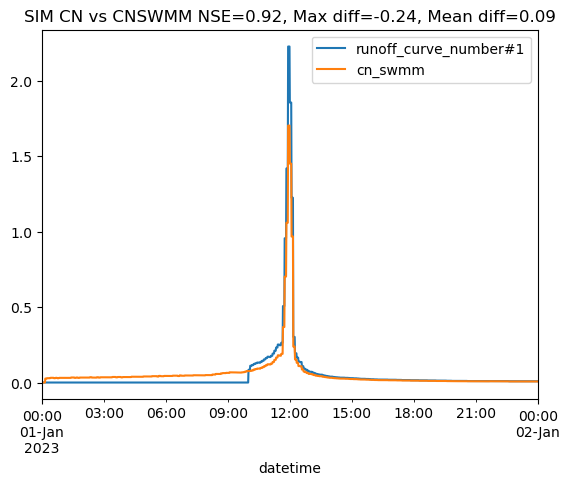

In [13]:
df = read_result(f, 'icm_sim', 'datetime', timestep)
target_fld='runoff_curve_number#1'
predict_fld='cn_swmm'
ax = df.loc[:, [target_fld, predict_fld]].plot(subplots=False)
s = compare(df, target_fld, predict_fld)
title = 'SIM CN vs CNSWMM NSE={nse:.2f}, Max diff={max_pct:.2f}, Mean diff={mean_pct:.2f}'.format(**s)
ax.set_title(title)

C:\Users\mengm\AppData\Local\Temp\ipykernel_5936\995160268.py:12: RuntimeWarning: invalid value encountered in double_scalars
  return (p-t)/t
C:\Users\mengm\AppData\Local\Temp\ipykernel_5936\995160268.py:12: RuntimeWarning: invalid value encountered in double_scalars
  return (p-t)/t
C:\Users\mengm\AppData\Local\Temp\ipykernel_5936\995160268.py:12: RuntimeWarning: invalid value encountered in double_scalars
  return (p-t)/t
C:\Users\mengm\AppData\Local\Temp\ipykernel_5936\995160268.py:12: RuntimeWarning: invalid value encountered in double_scalars
  return (p-t)/t
C:\Users\mengm\AppData\Local\Temp\ipykernel_5936\995160268.py:12: RuntimeWarning: invalid value encountered in double_scalars
  return (p-t)/t
C:\Users\mengm\AppData\Local\Temp\ipykernel_5936\995160268.py:12: RuntimeWarning: invalid value encountered in double_scalars
  return (p-t)/t


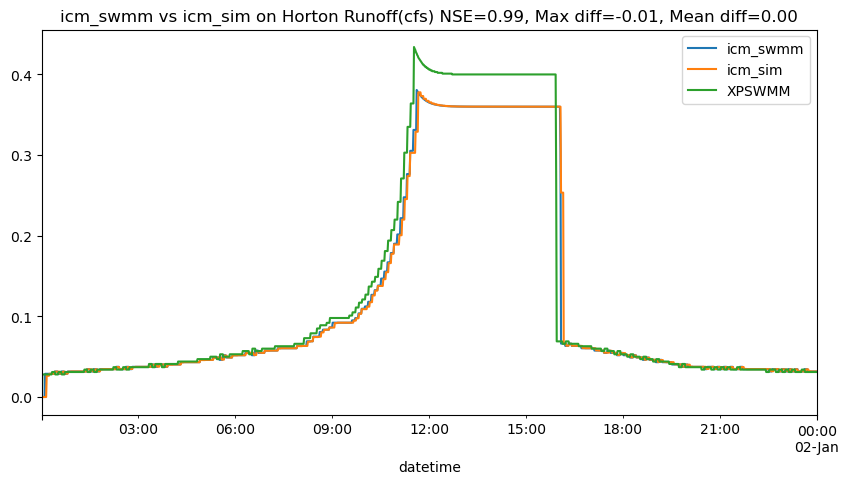

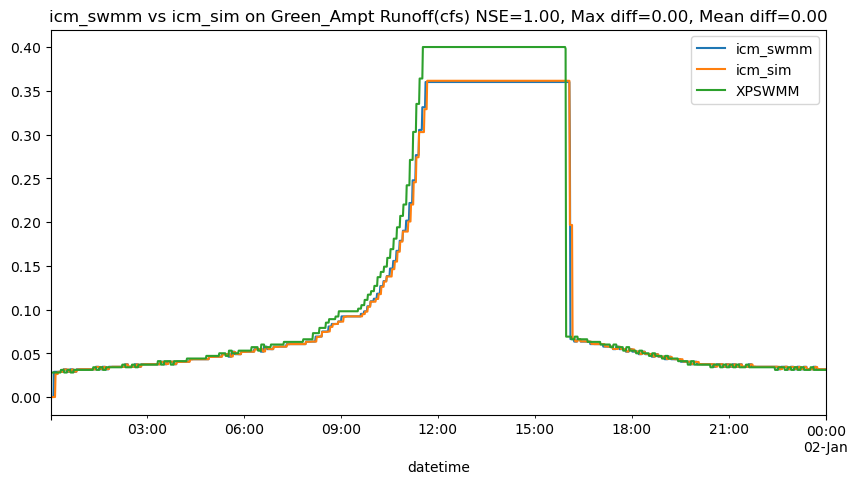

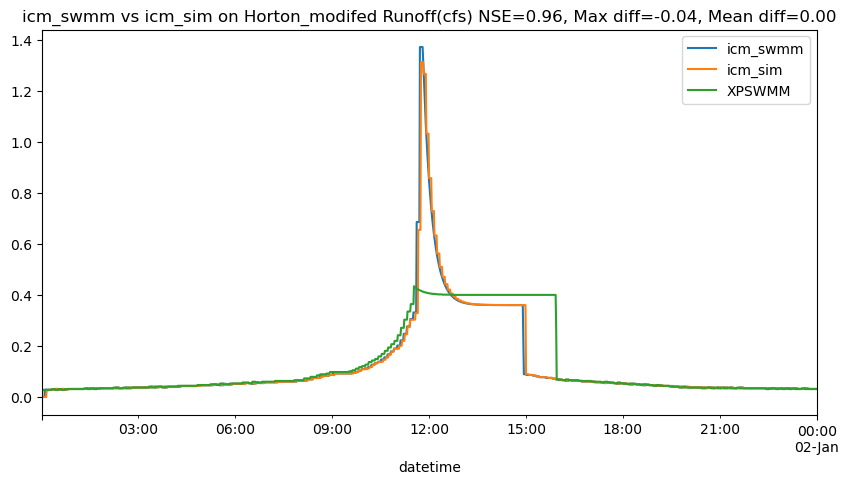

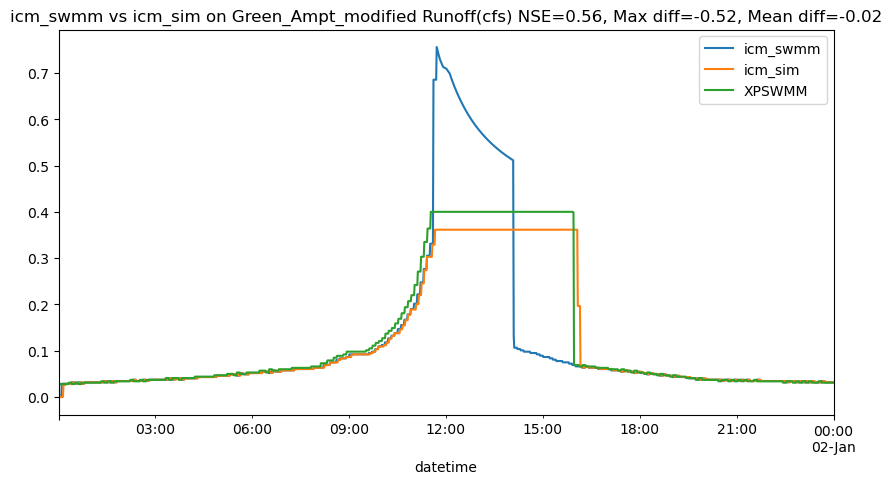

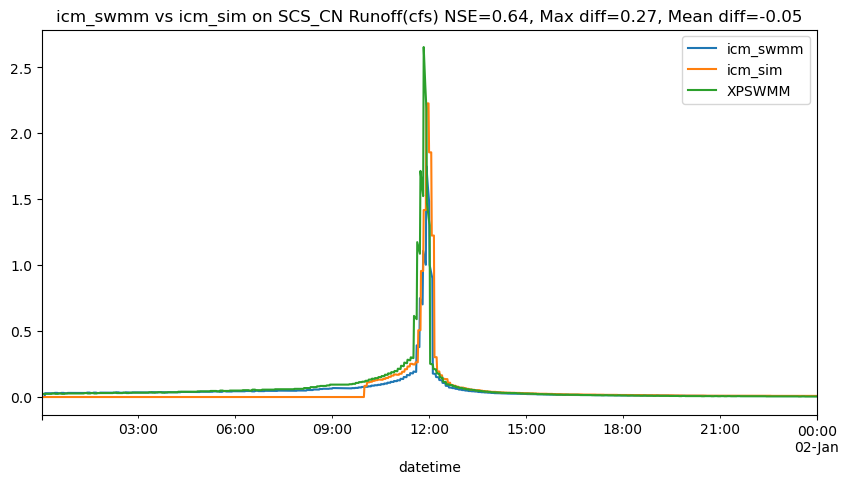

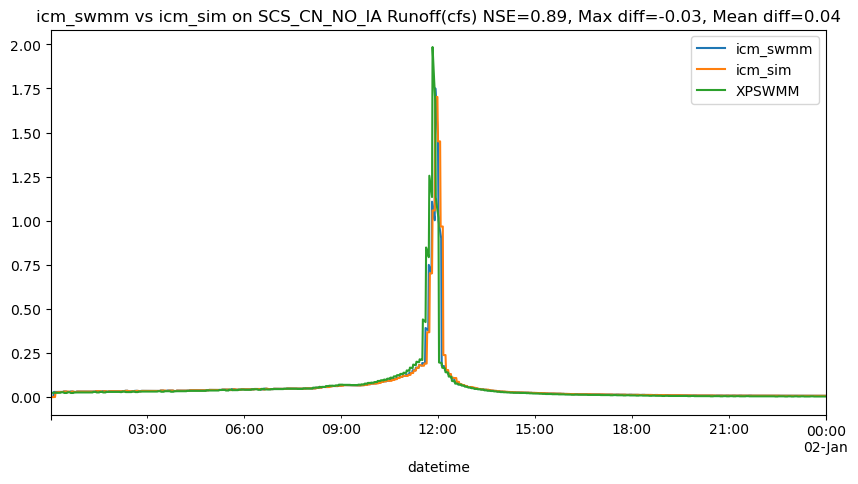

In [14]:
# join the runoff results from each tab into a single dataframe with the same index
for field in ['Horton', 'Green_Ampt', 'Horton_modifed', 'Green_Ampt_modified', 'SCS_CN', 'SCS_CN_NO_IA']:
    m = merge_results(data, mapping, field)
    # plot the comparison
    ax = m.plot(figsize=(10, 5))
    # calculate the statistis by comparing the results to SWMM5
    target_fld = 'icm_swmm'
    predict_fld = 'icm_sim'
    s = compare(m, target_fld, predict_fld)
    s['field'] = field
    s['target_fld'] = target_fld
    s['predict_fld'] = predict_fld
    title = '{target_fld} vs {predict_fld} on {field} Runoff(cfs) NSE={nse:.2f}, Max diff={max_pct:.2f}, Mean diff={mean_pct:.2f}'.format(**dict(s))
    ax.set_title(title)
